# Monte Carlo Methods

This Notebooks, Ressources, and Proofs: https://github.com/f-ilic/cib_semniar


                                                                                                        CI-B 2023
                                                                                                        Alexander & Filip

                                                                                                        

## Hello World: Monte Carlo Edition
### Estimating $\pi$


* $x,y \sim \mathcal{U_{[-1,1]}}.$
* Area of the square: $A_\square=4$
* Area of the circle: $A_O = \pi$
    * Is the sampled point inside of the the circle ($x^2 + y^2 < 1$)? 

$P(X) = \frac{A_O}{A_\square} = \frac{\pi}{4}$



In [45]:
# imports for the notebook
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
# import seaborn as sns
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib.patches import ConnectionPatch
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from matplotlib.artist import Artist
from scipy.stats import binom, norm

%matplotlib widget


interactive(children=(IntSlider(value=1, description='n', max=10000, min=1), Output()), _dom_classes=('widget-…

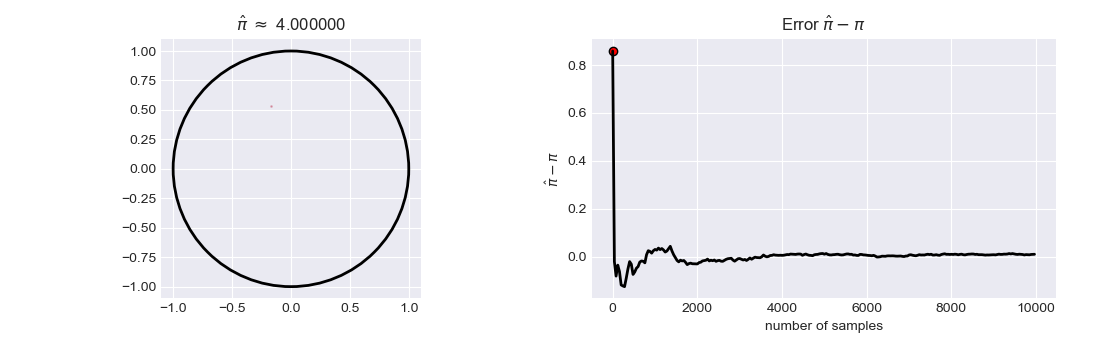

In [46]:
# Estimating Pi Example

def estimate_pi():
    num_samples = 10000
    np.random.seed(1)
    x = np.random.uniform(low=-1, high=1, size=num_samples)
    y = np.random.uniform(low=-1, high=1, size=num_samples)
    c = x**2 + y**2 < 1

    fig, axes = plt.subplots(1, 2, figsize=(11,3.5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax = axes[0]; er = axes[1]; fig.tight_layout(pad=2.5)
    er.set_xlim(0, num_samples)


    circle = plt.Circle((0, 0), 1, fill=False, linewidth=2)
    pi_t = [4*((sum(c[:i])/i))-np.pi for i in range(1,num_samples, 40)]

    @widgets.interact(n=(1, num_samples, 1))
    def update(n = 1):
        ax.clear(); ax.set_aspect('equal');
        er.clear(); er.grid('on'); 
        ax.scatter(x[:n], y[:n], c=c[:n], alpha=0.25, s=1, cmap='coolwarm_r')
        pi_hat = 4*((sum(c[:n])/n))
        ax.add_patch(circle)

        er.plot(range(1,num_samples, 40), pi_t, c='black', linewidth=2)
        er.scatter(n, pi_hat-np.pi, c='red', edgecolors='k')


        ax.set_title(r"$\hat{\pi}$ $\approx$ " + f"{pi_hat:.6f}")
        er.set_title(r"Error $\hat{\pi}-\pi$")
        er.set_xlabel("number of samples"); er.set_ylabel(r"$\hat{\pi}-\pi$")
estimate_pi()


# What are Monte Carlo Methods trying to achieve?




Goal: calculate $\mathop{\mathbb{E}}[f(x)] = \int f(\bold{x})~p(\bold{x})~d\bold{x}$

Idea: approximate it with $\mathbb{E}[f(x)] \approx \underbrace{\frac{1}{N} \sum_{i=1}^N(f(x_i))}_{s}, ~~~\text{where  } x_i \sim p(x)$

In general hard / impossible to compute the full $p(x)f(x)$ -> **We can not compute the integral this way**

In [47]:
# What is the underlying problem that we are trying to solve with Monte Carlo?
def intro():
    # plt.cla()
    # plt.clf()
    # plt.close()
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    xs = np.linspace(-5, 5, 1000)
    
    @widgets.interact(Expectation=False)
    def update(Expectation=False):
        gaussian1 = f(xs, -1, 0.8)* 0.8
        gaussian2 = f(xs, 2, 0.5)* 0.2
        sig = sigmoid(xs)*0.4 - f(xs, 0.4, 0.5)*0.2
        fig = plt.figure(figsize=(10,4))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        px = gaussian1 + gaussian2
        plt.plot(xs, px, '-b', label="p(x)")
        plt.plot(xs, sig, '-r', label="f(x)")
        plt.plot(xs, np.zeros_like(xs), '-k')
        plt.plot([-5,-5],[0, px.max()], '-k')

        # plt.xlim([-4, 4])

        if Expectation == True:
            AUC = np.trapz(sig*px, xs)
            plt.plot(xs, sig*px, color='purple')
            plt.plot([-4.9, -4], [AUC,AUC], 'purple', label=r"$\mathbb{E}$")
            plt.plot(-4.9, AUC, 'purple', marker="<")

            plt.fill_between(xs, sig*px, color='purple', alpha=0.2)
        plt.legend(loc='center right')
        # print(f'area = {np.trapz(sig*px, xs)}')
        plt.show()
intro()

interactive(children=(Checkbox(value=False, description='Expectation'), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=0, description='n'), Checkbox(value=False, description='Expectation'), O…

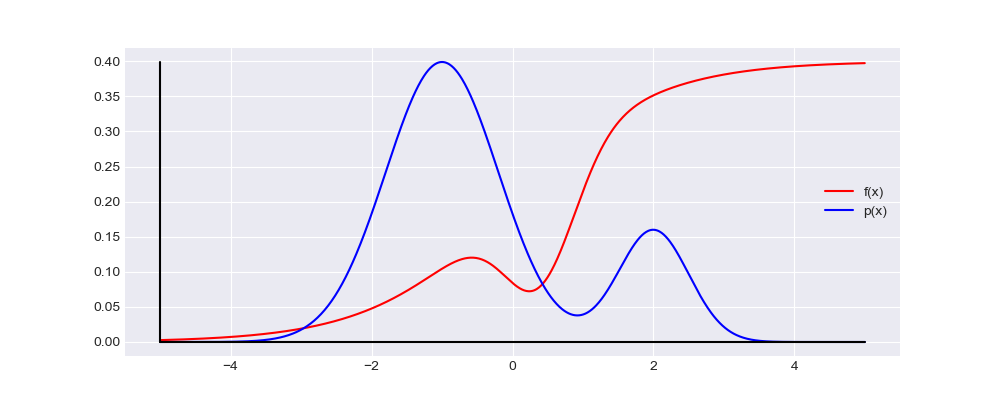

In [48]:
def core():
    num_samples = 100
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    def functional_sig(x):
        return sigmoid(x)*0.4 - f(x, 0.4, 0.5)*0.2
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -1, 0.8)* 0.8
    gaussian2 = f(xs, 2, 0.5)* 0.2
    fig, ax0 = plt.subplots(1,1, figsize=(10,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    sig = [functional_sig(x) for x in xs]


    pdf = gaussian1 + gaussian2
    cdf = np.cumsum(pdf)

    rands = np.random.uniform(low=0, high=cdf.max(), size=num_samples)

    @widgets.interact(Expectation=False, n=(0, num_samples, 1))
    def update(n = 0, Expectation=False):
        ax0.clear();
        ax0.plot(xs, sig, '-r', label="f(x)")

        ax0.plot(xs, pdf, '-b', label="p(x)")
        ax0.plot(xs, np.zeros_like(xs), '-k')
        ax0.plot([-5,-5],[0, pdf.max()], '-k')
        # ax0.set_ylabel("PDF")
        # ax0.set_yticklabels([])
        
        if n != 0:
            x_pt = []
            y_pt = []
            random_samples = rands[:n]
            for i in list(random_samples):
                closest_intercept = (np.abs(cdf - i)).argmin()
                value = cdf[closest_intercept]
                xval = xs[closest_intercept]
                x_pt.append(xval)
                y_pt.append(value)

            list_pfs = []
            for x,y in zip(x_pt, y_pt):
                ax0.plot(x, 0,'b|', alpha=0.3, markersize=10, linewidth=100)
                if Expectation == True:
                    ax0.plot(-5, functional_sig(x), 'b_', alpha=0.3, markersize=10, linewidth=100)
                    ax0.plot([-5, x], [functional_sig(x),functional_sig(x)],'b-', alpha=0.08)
                    ax0.plot([x,x], [0,functional_sig(x)],'b-', alpha=0.08)
                    ax0.plot(-5, functional_sig(x),'b-')
                    list_pfs.append(functional_sig(x))

            if Expectation == True:
                ax0.plot(-4.9,np.array(list_pfs).mean(), 'purple', marker="<")
                ax0.plot([-4.9, -4], [np.array(list_pfs).mean(), np.array(list_pfs).mean()], 'purple', label=r"$\mathbb{E}$")
        ax0.legend(loc='center right')
        # print(np.array(list_pfs).mean())
core()

Reminder: $\mathbb{E}[f(x)] \approx \underbrace{\frac{1}{N} \sum_{i=1}^N(f(x_i))}_{s}, ~~~\text{where  } x_i \sim p(x)$


interactive(children=(IntSlider(value=1, description='n', max=1000, min=1, step=20), IntSlider(value=1, descri…

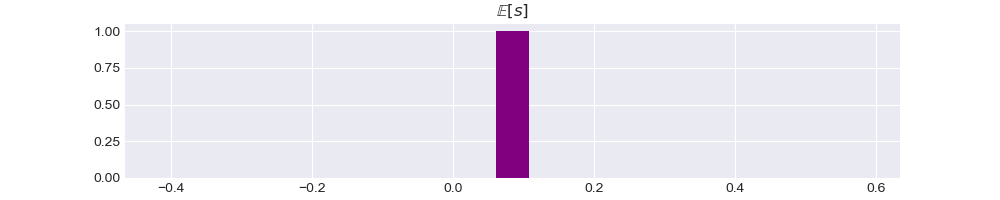

In [49]:
def central_limit_expectation():
    num_samples = 1000
    num_averages = 1000
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    def functional_sig(x):
        return sigmoid(x)*0.4 - f(x, 0.4, 0.5)*0.2
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -1, 0.8)* 0.8
    gaussian2 = f(xs, 2, 0.5)* 0.2
    fig, ax0 = plt.subplots(1,1, figsize=(10,2))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    sig = [functional_sig(x) for x in xs]

    pdf = gaussian1 + gaussian2
    cdf = np.cumsum(pdf)


    @widgets.interact(n=(1, num_samples, 20),s=(1, num_averages, 10))
    def update(n = 1, s=1):
        ax0.clear();

        averages = []
        for i in range(s):
            rands = np.random.uniform(low=0, high=cdf.max(), size=num_samples)

            if n != 0:
                x_pt = []
                y_pt = []
                random_samples = rands[:n]
                for i in list(random_samples):
                    closest_intercept = (np.abs(cdf - i)).argmin()
                    value = cdf[closest_intercept]
                    xval = xs[closest_intercept]
                    x_pt.append(xval)
                    y_pt.append(value)

                list_pfs = []
                for x,y in zip(x_pt, y_pt):
                    list_pfs.append(functional_sig(x))
            averages.append(np.array(list_pfs).mean())
        ax0.set_title(r"$\mathbb{E}[s]$")
        ax0.hist(averages, bins=21, color='purple')
central_limit_expectation()

* Width = $2 \sqrt(\mathbb{V}_p[s])$
* $\mathbb{V}_p[s] = \frac{1}{N}\mathbb{V}_p[f(x)]\qquad$   **Variance Decreases with number of samples!**


### Central Limit Theorem

$s \rightarrow \mathcal{N}(\sigma, \mu^2) 
\begin{cases} 
\mu &= \mathbb{E}[f(x)]\\
\sigma^2 &= \frac{1}{N} \mathbb{V}[f(x)]
\end{cases}$



In reality you only get one sampling of $s$!





### Convergence

* $\mathbb{E}_p[f(x)] = \int p(x) f(x) dx\qquad$   **Unbiased Estimator**
* $\mathbb{V}_p[f(x)] = \frac{\sigma^2_f}{N} = \mathcal{O} \frac{1}{N}\qquad$   **Independent of dimension d**


# Sampling
* How do we sample from arbitrary distributions?
* How did I produce the $p(x)$ samples in the examples above?

# Rejection Sampling 

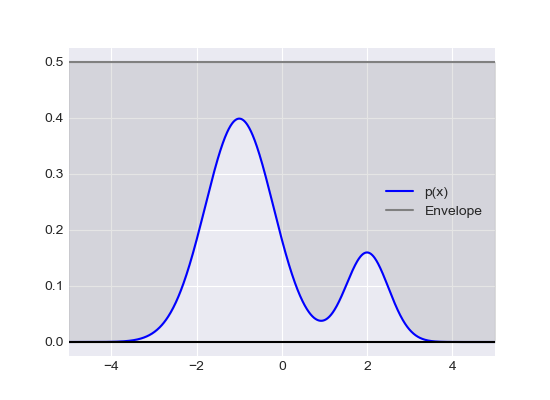

In [50]:
# Rejection Sampling TL;DR
def intro():
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -1, 0.8)* 0.8
    gaussian2 = f(xs, 2, 0.5)* 0.2
    gaus = f(xs,0,2.3)*3
    uniform = np.ones_like(xs)*0.5

    fig, ax_u = plt.subplots(1,1, figsize=(5.5,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    # ax_u = axes[0]
    # ax_n = axes[1]

    px = gaussian1 + gaussian2


    ax_u.fill_between(xs, uniform, px, alpha=0.2, color='gray')
    ax_u.plot(xs, px, '-b', label="p(x)")
    ax_u.plot(xs, uniform, color='gray', label="Envelope")
    ax_u.plot(xs, np.zeros_like(xs), '-k')
    ax_u.legend()
    ax_u.set_xlim([-5, 5])

    plt.show()

intro()

Basic Idea same as the $\pi$ example!

1) Take a distribution $Env$ that we know how to sample from (Uniform 😬)
2) Scale it so it covers the target distribution
3) Sample from $Env$ and reject them if they in the gray area!


## From Uniform to Normal (with rejection sampling)

$\mathcal{U_{[0,1]}}  \rightarrow \mathcal{N}(\mu,\,\sigma^{2})$ ?

interactive(children=(IntSlider(value=500, description='n_samples', max=100000, min=1, step=5), IntSlider(valu…

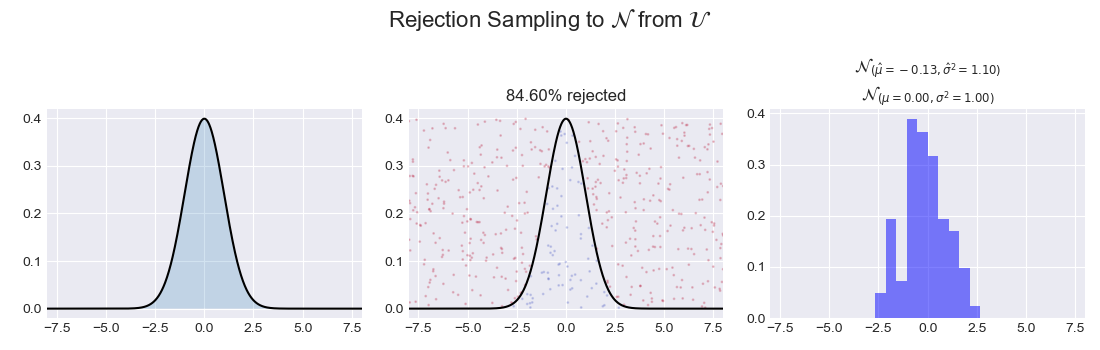

In [51]:
# Rejection sampling to a Gaussian
def rejection_sampling_gauss():
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

    fig, reject_gauss_ax = plt.subplots(1,3,  figsize=(11, 3.5))

    # reject_gauss_ax[0].set_xlim([0, 1]), reject_gauss_ax[0].set_ylim([0, 1.25])
    n_max_samples = 100000
    
    xbound = 8
    x_all = np.random.uniform(low=-xbound, high=xbound,size=n_max_samples)
    y_all = np.random.uniform(low=0, high=1, size=n_max_samples)
    fig.suptitle(r"Rejection Sampling to $\mathcal{N}$ from $\mathcal{U}$", fontsize=16)
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    @widgets.interact(n_samples=(1, n_max_samples, 5), n_bins=(1,50,1), sigma2=(0.2, 5, 0.01), mean=(-5, 5, 0.01))
    def update(n_samples = 500, n_bins=10, sigma2=1, mean=0):
        xs = np.linspace(-xbound, xbound, 1000)
        sigma2=sigma2**(1/2)
        ys = f(xs, mean, sigma2)

        x = x_all[:n_samples]
        y = y_all[:n_samples]*ys.max() # y_all is 0-1, so scale it to the max of the gaussian (*1.1 to make it a bit bigger)
        reject_gauss_ax[0].clear(); reject_gauss_ax[1].clear(); reject_gauss_ax[2].clear()
        c = y<f(x, mean, sigma2)

        reject_gauss_ax[0].plot(xs, ys, label="Forward Function", c='k') 
        reject_gauss_ax[0].fill_between(xs, ys, 0, alpha=0.2)
        reject_gauss_ax[0].set_xlim([-xbound, xbound]), 

        reject_gauss_ax[1].plot(xs, ys, c='k')
        reject_gauss_ax[1].scatter(x, y, alpha=0.2, label="Samples", c=c, cmap='coolwarm_r', s=1)
        reject_gauss_ax[1].set_xlim([-xbound, xbound]),
        reject_gauss_ax[1].set_title(f"{100*(1-sum(c)/n_samples):.2f}% rejected")


        # reject_gauss_ax[2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

        reject_gauss_ax[2].hist(x[c], bins=n_bins, density=True, alpha=0.5, label="Rejection Sampled", color='blue')
        reject_gauss_ax[2].set_xlim([-xbound, xbound]),
        mean_est = np.mean(x[c])
        sigma2_est = np.std(x[c])
        # reject_gauss_ax[2].set_title(r"$\mathcal{N}(\mu,\,\sigma^{2})$")
        reject_gauss_ax[2].set_title(r"$\mathcal{N}_{(\hat{\mu}=%.2f, \hat{\sigma}^2=%.2f)}$" "\n" r"$\mathcal{N}_{(\mu=%.2f, \sigma^2=%.2f)}$"%(mean_est, sigma2_est, mean, sigma2))
        fig.tight_layout()

rejection_sampling_gauss()

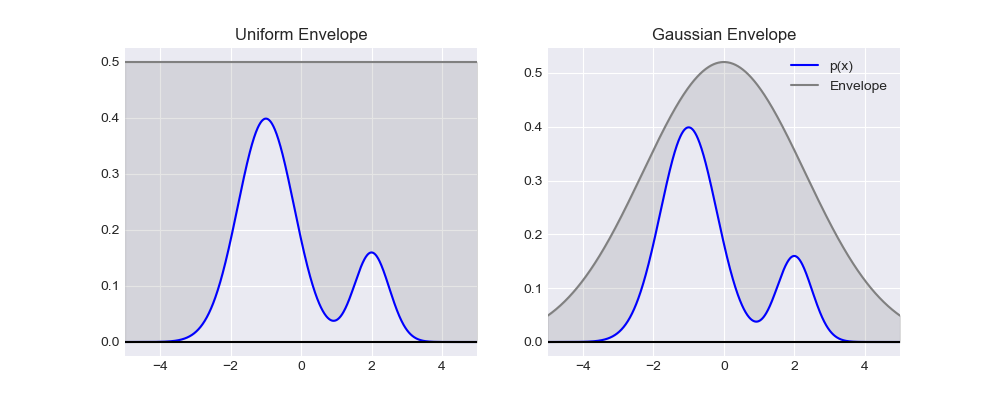

In [52]:
# Choice of envelope function
def intro_2():
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -1, 0.8)* 0.8
    gaussian2 = f(xs, 2, 0.5)* 0.2
    gaus = f(xs,0,2.3)*3
    uniform = np.ones_like(xs)*0.5

    fig, axes = plt.subplots(1,2, figsize=(10,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    ax_u = axes[0]
    ax_n = axes[1]

    px = gaussian1 + gaussian2

    ax_n.fill_between(xs, gaus, px, alpha=0.2, color='gray')
    ax_n.plot(xs, px, '-b', label="p(x)")
    ax_n.plot(xs, gaus, color='gray', label="Envelope")
    ax_n.plot(xs, np.zeros_like(xs), '-k')
    ax_n.legend()
    ax_n.set_xlim([-5, 5])
    ax_n.set_title("Gaussian Envelope")


    ax_u.fill_between(xs, uniform, px, alpha=0.2, color='gray')
    ax_u.plot(xs, px, '-b', label="p(x)")
    ax_u.plot(xs, uniform, color='gray', label="Envelope")
    ax_u.plot(xs, np.zeros_like(xs), '-k')
    # ax_u.legend()
    ax_u.set_xlim([-5, 5])
    ax_u.set_title("Uniform Envelope")


    plt.show()

intro_2()

**Drawbacks**:

* We are possibly computing a lot of samples that we don't *need*
* Depends a lot on the choice of Envelope
    * What to do functions with infinite support?


# Inversion Sampling


**PDF** *(Probability Density Function)*

$f_X(x) = \begin{cases}
   0,& x <  0\\
   e^{-x},        & x \geq 0
\end{cases}
\qquad
\begin{aligned}
P(1 < X < 3) &= \int_1^3 f_X(x) dx \\
             &= \int_1^3 e^{-x} dx \\
             &= e^{-1} - e^{-3}
\end{aligned}
$

**CDF** *(Cumulative Density Function)*

$
\begin{aligned}
F_X(x) &= P(X \leq x) = \int_{-\infty}^x f_X(x)~dx =  \int_{-\infty}^0 f_X(x)~dx +  \int_{0}^x f_X(x)~dx \\
       &= \int_{0}^x f_X(x)~dx \\
       &= \int_{0}^x e^{-x}~dx \\
       &= 1-e^{-x} \\
\end{aligned}
$

$
\begin{aligned}
P(1 < X < 3) &= P(X \leq 3) - P(X \leq 1)\\
             &=F_X(3) - F_X(1)
\end{aligned}
$

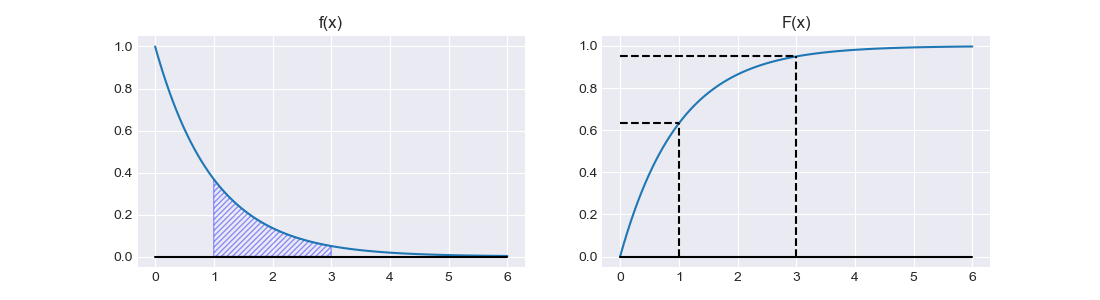

In [54]:
# Reminder PDF and CDF
def gaussian(x):
    return np.exp(-x)
def F(x):
    return 1-np.exp(-x)

fig, axes = plt.subplots(1,2, figsize=(11,3))
ax0, ax1 = axes.ravel()
fig.canvas.toolbar_visible = False; fig.canvas.header_visible = False; fig.canvas.footer_visible = False
xs = np.linspace(0, 6, 100)
ys = gaussian(xs)
integral = np.linspace(1,3,100)
ax0.fill_between(integral, gaussian(integral), 0, color='none', hatch='//////', alpha=0.4, edgecolor="b")
ax0.plot(xs, ys)
ax0.set_title("f(x)")
ax0.plot(xs, np.zeros_like(xs), '-k')

ax1.plot(xs, F(xs))
ax1.set_title("F(x)")
ax1.plot([1,1], [0,F(1)], '--k'); ax1.plot([3,3], [0,F(3)], '--k')
ax1.plot([0,1], [F(1),F(1)], '--k'); ax1.plot([0,3], [F(3),F(3)], '--k')
ax1.plot(xs, np.zeros_like(xs), '-k')

plt.show()

interactive(children=(IntSlider(value=1, description='n', max=3000, min=1, step=100), Checkbox(value=False, de…

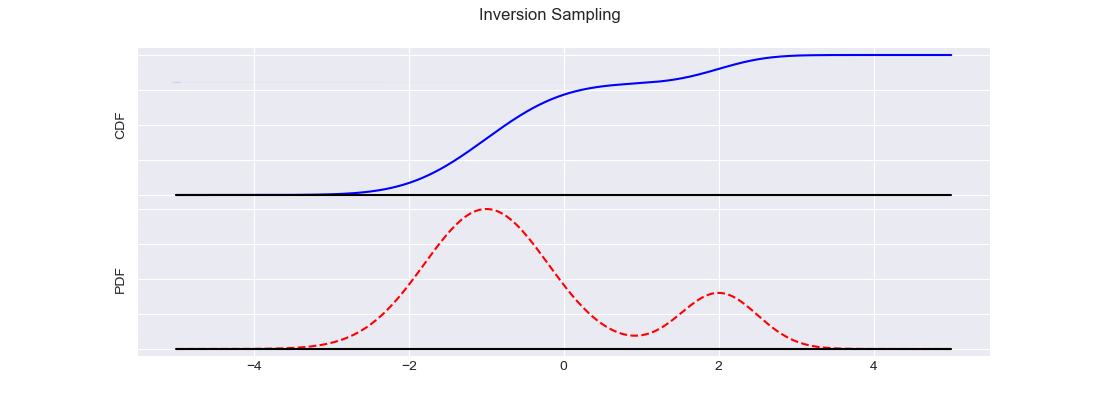

In [55]:
# Inversion Sampling
def inversion_sampling():
    num_samples = 3000
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -1, 0.8)* 0.8
    gaussian2 = f(xs, 2, 0.5)* 0.2
    fig, axes = plt.subplots(2,1, figsize=(11,4), sharex=False, sharey=False, gridspec_kw={'hspace': 0})
    fig.suptitle("Inversion Sampling")
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax0, ax1 = axes[0], axes[1]

    pdf = gaussian1 + gaussian2
    cdf = np.cumsum(pdf)

    rands = np.random.uniform(low=0, high=cdf.max(), size=num_samples)

    @widgets.interact(Show_Inversion_Sampling=False, n=(1, num_samples, 100))
    def update(n = 0, Show_Inversion_Sampling=False):
        ax0.clear(); ax1.clear()


        ax0.plot(xs, cdf, '-b', label="F(x)")
        ax0.plot(xs, np.zeros_like(xs), '-k')

        
        ax0.set_ylabel("CDF")
        ax0.set_yticklabels([])

        ax1.plot(xs, pdf, '--r', label="f(x)")
        ax1.plot(xs, np.zeros_like(xs), '-k')
        ax1.set_ylabel("PDF")
        ax1.set_yticklabels([])
        
        x_pt = []
        y_pt = []
        random_samples = rands[:n]
        for i in list(random_samples):
            closest_intercept = (np.abs(cdf - i)).argmin()
            value = cdf[closest_intercept]
            xval = xs[closest_intercept]
            x_pt.append(xval)
            y_pt.append(value)
            ax0.plot([-5, xval], [i, value], 'b-', alpha=0.01, linewidth=1)
            ax0.plot(-5, i, 'b_', alpha=0.1, linewidth=1)

        if Show_Inversion_Sampling==True:
            for x,y in zip(x_pt, y_pt):
                pdf_xy = (x, 0)
                cdf_xy = (x, y)
                con = ConnectionPatch(xyA=cdf_xy, xyB=pdf_xy, coordsA="data", coordsB="data", axesA=ax0, axesB=ax1, color="blue", alpha=0.01)
                ax1.plot(x, 0,'b|', alpha=0.1)
                ax1.add_artist(con)

inversion_sampling()

### Inversion Sampling Summary

* You need access to the CDF
    * Often times this is possible in the real world; think physical experiments
* Elegent solution that does not do any *unneccessary* computation
* Does not scale well to higher dimensions

# Importance Sampling

interactive(children=(IntSlider(value=0, description='n', max=30), IntSlider(value=0, description='rand_seed')…

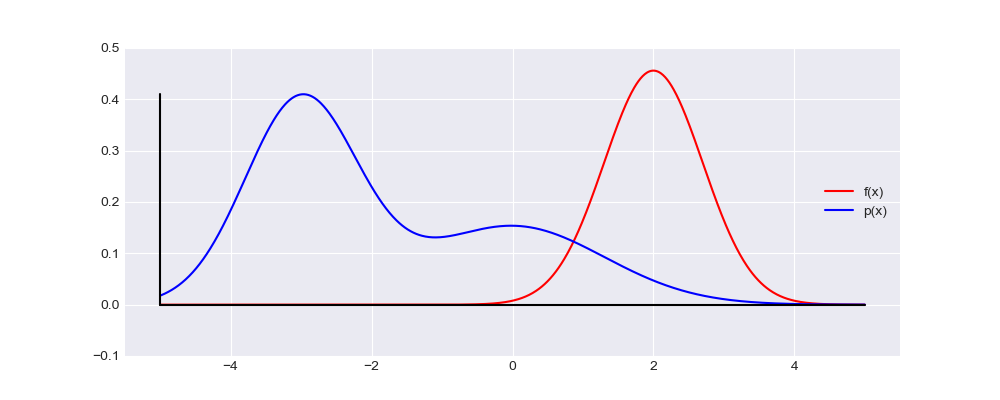

In [56]:
def imporance_sampling_problem():
    num_samples = 30
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    def functional_sig(x):
        return f(x, 2, 0.7)* 0.8
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -3, 0.8)* 0.8
    gaussian2 = f(xs, 0, 1.3)* 0.5
    fig, ax0 = plt.subplots(1,1, figsize=(10,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fx = [functional_sig(x) for x in xs]

    pdf = gaussian1 + gaussian2
    cdf = np.cumsum(pdf)


    @widgets.interact(n=(0, num_samples, 1), rand_seed=(0, 100, 1))
    def update(n = 0, rand_seed=0):
        np.random.seed(rand_seed)
        rands = np.random.uniform(low=0, high=cdf.max(), size=num_samples)

        ax0.clear();
        ax0.plot(xs, fx, '-r', label="f(x)")

        ax0.plot(xs, pdf, '-b', label="p(x)")
        ax0.plot(xs, np.zeros_like(xs), '-k')
        ax0.plot([-5,-5],[0, pdf.max()], '-k')
        
        if n != 0:
            x_pt = []
            y_pt = []
            random_samples = rands[:n]
            for i in list(random_samples):
                closest_intercept = (np.abs(cdf - i)).argmin()
                value = cdf[closest_intercept]
                xval = xs[closest_intercept]
                x_pt.append(xval)
                y_pt.append(value)

            list_pfs = []
            for x,y in zip(x_pt, y_pt):
                ax0.plot(x, 0,'b|', alpha=0.3, markersize=10, linewidth=100)
                ax0.plot(-5, functional_sig(x), 'b_', alpha=0.3, markersize=10, linewidth=100)
                ax0.plot([-5, x], [functional_sig(x),functional_sig(x)],'b-', alpha=0.08)
                ax0.plot([x,x], [0,functional_sig(x)],'b-', alpha=0.08)
                ax0.plot(-5, functional_sig(x),'b-')
                list_pfs.append(functional_sig(x))

            ax0.plot(-4.9,np.array(list_pfs).mean(), 'purple', marker="<")
            ax0.plot([-4.9, -4], [np.array(list_pfs).mean(), np.array(list_pfs).mean()], 'purple', label=r"$\mathbb{E}$")
            ax0.errorbar(-4.5, np.array(list_pfs).mean(), np.array(list_pfs).std(), label=r"$\mathbb{V}$")

        ax0.legend(loc='center right')
        ax0.set_ylim([-0.1, 0.5])
imporance_sampling_problem()

The problem: $f(x)$ is large **only** in regions where $p(x)$ is small.
* The variance $\mathbb{V}$ for different evaluations of $\mathbb{E}_p$ is large.

### Remember: 

$\mathop{\mathbb{E}}[f(x)]$ is what we want to approxmiate

$
\begin{aligned}
\mathop{\mathbb{E_p}}[f(x)] &= \int p(\bold{x})~f(\bold{x})~d\bold{x}  \qquad | \text{multiply by } \frac{q(x)}{q(x)}\\
                          &= \int q(x) \left[\frac{p(x)}{q(x)}  f(x) \right] dx \\
                          &= \mathbb{E}_q \left[\frac{p(x)}{q(x)} f(x) \right]
\end{aligned}
$

### We can estimate this with samples $x_i \sim q$ 

$
\begin{aligned}
\mathbb{E}_q \left[\frac{p(x)}{q(x)} f(x) \right] \approx \underbrace{\frac{1}{N} \sum_{i=1}^N\frac{p(x_i)}{q(x_i)} f(x_i)}_{r}
\end{aligned}
$ 


### Convergence

* Unbiased $\mathbb{E}_q[r] = \mathbb{E}_p[f(x)]$
* Same or better variance $\mathbb{V}_q[r] = \frac{1}{N} \mathbb{V}_q \left[\frac{p(x)}{q(x)} f(x) \right]$
    * choose $q$ such that $\mathbb{V}_q \left[\frac{p(x)}{q(x)} f(x) \right] < \mathbb{V}_p[f(x)]$

We can achieve this by chosing $q(x)$ to be high were $|p(x)f(x)|$ is high.



interactive(children=(Checkbox(value=True, description='fx_plt'), Checkbox(value=True, description='px_plt'), …

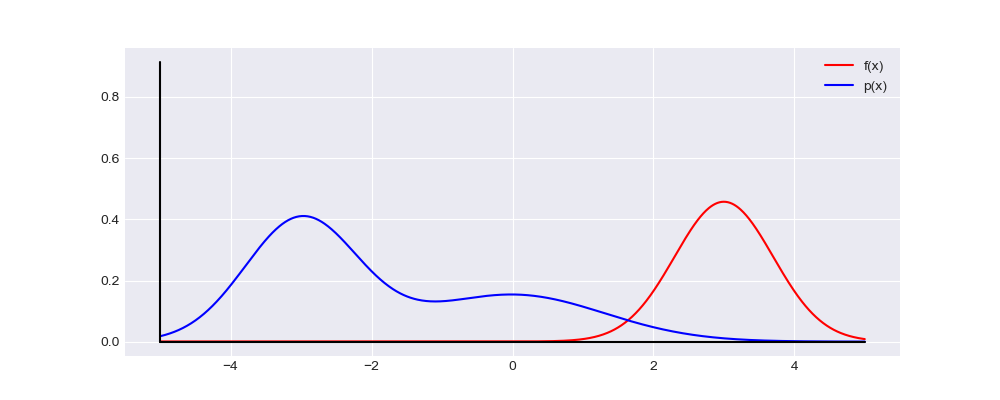

In [61]:
def imporance_sampling_q():
    num_samples = 30
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))+ 0.001
    
    def functional_sig(x):
        return f(x, 3, 0.7)* 0.8+ 0.001
    
    xs = np.linspace(-5, 5, 1000)

    fig, ax0 = plt.subplots(1,1, figsize=(10,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    fx = [functional_sig(x) for x in xs]
    px = f(xs, -3, 0.8)* 0.8 + f(xs, 0, 1.3)* 0.5
    qx = f(xs, 2, 1.1)* 0.8
    fxpxqx = fx*(px/qx)

    rands = np.random.uniform(low=0, high=max(fx), size=num_samples)
    @widgets.interact(fx_plt=True, px_plt=True, qx_plt=False, fxpxqx_plt=False)
    def update(fx_plt=True, px_plt=True, qx_plt=False, fxpxqx_plt=False):
        plt.cla()
        # plt.clf()
        if fxpxqx_plt == True:
            ax0.plot(xs, fxpxqx, '-r', label=r"$\frac{px}{qx} f(x)$")
        if fx_plt == True:
            ax0.plot(xs, fx, '-r', label="f(x)")
        if px_plt == True:
            ax0.plot(xs, px, '-b', label="p(x)")
        if qx_plt == True:
            ax0.plot(xs, qx, '-g', label="q(x)")

        ax0.plot(xs, np.zeros_like(xs), '-k')
        ax0.plot([-5,-5],[0, max(fxpxqx)], '-k')
        
        plt.legend(loc='upper right')
        # plt.show()
imporance_sampling_q()

$
\begin{aligned}
\mathbb{E}_q \left[\frac{p(x)}{q(x)} f(x) \right] \approx \underbrace{\frac{1}{N} \sum_{i=1}^N\frac{p(x_i)}{q(x_i)} f(x_i)}_{r}, \text{with } x_i \sim q
\end{aligned}
$ 

interactive(children=(IntSlider(value=0, description='n', max=30), IntSlider(value=0, description='rand_seed')…

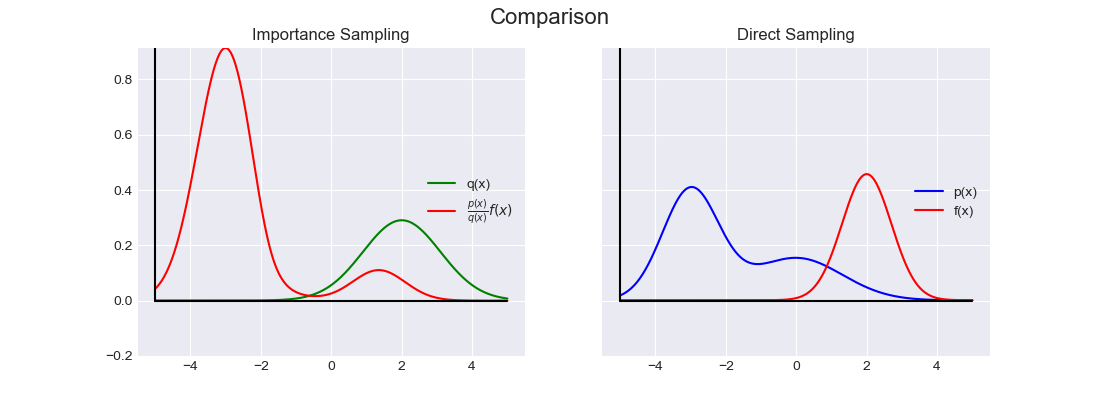

In [63]:
def imporance_sampling_final():
    num_samples = 30
    def gauss(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))+ 0.001
    
    def functional_f(x):
        return gauss(x, 2, 0.7)* 0.8+ 0.001
    
    def functional_p(x):
        return gauss(x, -3, 0.8)* 0.8 + gauss(x, 0, 1.3)* 0.5

    def functional_q(x):
        return gauss(x, 2, 1.1)* 0.8
    
    def functional_fpx(x):
        return functional_f(x)*(functional_p(x)/functional_q(x))
    
    xs = np.linspace(-5, 5, 1000)

    fig, axes = plt.subplots(1,2, figsize=(11,4), sharey=True)
    ax0, ax1 = axes.ravel()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False


    fx = [functional_f(x) for x in xs]
    px = [functional_p(x) for x in xs]
    qx = [functional_q(x) for x in xs]
    fxpxqx = [functional_fpx(x) for x in xs]

    cdf_IS = np.cumsum(qx)
    cdf = np.cumsum(px)


    @widgets.interact(n=(0, num_samples, 1), rand_seed=(0, 100, 1))
    def update(n = 0, rand_seed=0):
        np.random.seed(rand_seed)
        rands_IS = np.random.uniform(low=0, high=max(cdf_IS), size=num_samples)

        ax0.clear();
        ax0.plot(xs, qx, '-g', label="q(x)")
        ax0.plot(xs, fxpxqx, '-r', label=r"$\frac{p(x)}{q(x)} f(x)$")

        ax0.plot(xs, np.zeros_like(xs), '-k')
        ax0.plot([-5,-5],[0, max(fxpxqx)], '-k')
        
        if n != 0:
            x_pt = []
            y_pt = []
            random_samples = rands_IS[:n]
            for i in list(random_samples):
                closest_intercept = (np.abs(cdf_IS - i)).argmin()
                value = cdf_IS[closest_intercept]
                xval = xs[closest_intercept]
                x_pt.append(xval)
                y_pt.append(value)

            list_pfs = []
            for x,y in zip(x_pt, y_pt):
                ax0.plot(x, 0,'g|', alpha=0.3, markersize=10, linewidth=100)
                ax0.plot(-5, functional_fpx(x), 'g_', alpha=0.3, markersize=10, linewidth=100)
                # ax0.plot([-5, x], [functional_fpx(x),functional_fpx(x)],'g-', alpha=0.08)
                # ax0.plot([x,x], [0,functional_fpx(x)],'g-', alpha=0.08)
                ax0.plot(-5, functional_fpx(x),'g-')
                list_pfs.append(functional_fpx(x))

            ax0.plot(-4.8,np.array(list_pfs).mean(), 'purple', marker="<")
            ax0.plot([-4.8, -4], [np.array(list_pfs).mean(), np.array(list_pfs).mean()], 'purple', label=r"$\mathbb{E}$")
            ax0.errorbar(-4.5, np.array(list_pfs).mean(), np.array(list_pfs).std(), label=r"$\mathbb{V}$")

        ax0.legend(loc='center right')

        np.random.seed(rand_seed)
        rands = np.random.uniform(low=0, high=max(cdf), size=num_samples)

        ax1.clear();
        ax1.plot(xs, px, '-b', label="p(x)")
        ax1.plot(xs, fx, '-r', label="f(x)")

        ax1.plot(xs, np.zeros_like(xs), '-k')
        ax1.plot([-5,-5],[0, max(fxpxqx)], '-k')
        
        if n != 0:
            x_pt = []
            y_pt = []
            random_samples = rands[:n]
            for i in list(random_samples):
                closest_intercept = (np.abs(cdf - i)).argmin()
                value = cdf[closest_intercept]
                xval = xs[closest_intercept]
                x_pt.append(xval)
                y_pt.append(value)

            list_pfs = []
            for x,y in zip(x_pt, y_pt):
                ax1.plot(x, 0,'b|', alpha=0.3, markersize=10, linewidth=100)
                ax1.plot(-5, functional_f(x), 'b_', alpha=0.3, markersize=10, linewidth=100)
                # ax1.plot([-5, x], [functional_f(x),functional_f(x)],'b-', alpha=0.08)
                # ax1.plot([x,x], [0,functional_f(x)],'b-', alpha=0.08)
                ax1.plot(-5, functional_f(x),'b-')
                list_pfs.append(functional_f(x))

            ax1.plot(-4.8,np.array(list_pfs).mean(), 'purple', marker="<")
            ax1.plot([-4.8, -4], [np.array(list_pfs).mean(), np.array(list_pfs).mean()], 'purple', label=r"$\mathbb{E}$")
            ax1.errorbar(-4.5, np.array(list_pfs).mean(), np.array(list_pfs).std(), label=r"$\mathbb{V}$")
        ax1.legend(loc='center right')

        ax0.set_ylim([-0.2, max(fxpxqx)])
        ax1.set_ylim([-0.2, max(fxpxqx)])
        ax0.set_title("Importance Sampling")
        ax1.set_title("Direct Sampling")
        fig.suptitle("Comparison", fontsize=16)

imporance_sampling_final()

# Takeaways

* Monte Carlo Methods estimate the Expectation

* There are some smart ways to lower the Variance of your estimate

* Common stragetegies
    * **Rejection** Sampling
    * **Inversion** Sampling
    * **Importance** Sampling

# BONUS: Binomial distribution $\rightarrow \mathcal{N} $ 

Another method of estimating empirically a normal distribution is the binomial distribution


interactive(children=(IntSlider(value=1, description='k', max=32, min=1), Output()), _dom_classes=('widget-int…

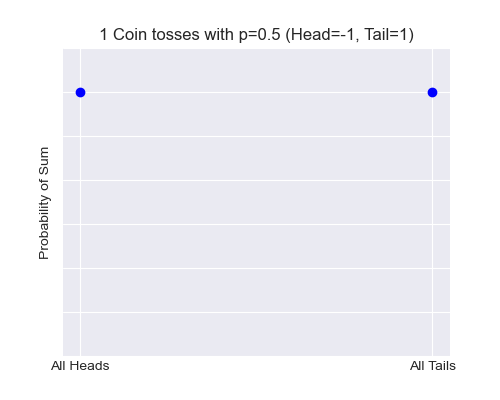

In [68]:
# Practical Example, Transition to MCMC
def galton():
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    @widgets.interact(k=(1, 32, 1))
    def update(k = 1):
        ax.clear()
        def pascal_triangle_row(k):
            row = [1]
            for i in range(k):
                row.append(row[i] * (k - i) // (i + 1))
            return row
        
        row = pascal_triangle_row(k)
        max = 2**k
        ax.set_yticklabels([])
        ax.set_ylabel("Probability of Sum")
        ax.set_xticks([0, k])  # Set only two ticks at the extremes
        ax.set_xticklabels(['All Heads', 'All Tails'])  # 
        ax.set_ylim([-0.1, 0.6])
        ax.plot([en for en, i in enumerate(row)], [r/max for r in row], 'bo')
        ax.set_title(f'{k} Coin tosses with p=0.5 (Head=-1, Tail=1)')

galton()

Galton Board as Monte-Carlo Markov-Chain **(MCMC)**: https://vknight.org/blog/posts/galton-board/

# BONUS 2: Box-Müller Method for $\mathcal{U} \rightarrow \mathcal{N}$

### How does it work?

**Cartesian form**

$z0  = \sqrt{-2~ln~u_1} cos(2\pi u_2)$ 

$z1  = \sqrt{-2~ln~u_1} sin(2\pi u_2)$


**Polar form**


$
\begin{aligned}
z0 = r~cos \phi\\
z1 = r~sin \phi
\end{aligned}$

where,

$
\begin{aligned}
r &= \sqrt{-2~ln~u_1}\\
\phi &= 2\pi u_2
\end{aligned}
$

interactive(children=(IntSlider(value=1, description='n', max=10000, min=1), Output()), _dom_classes=('widget-…

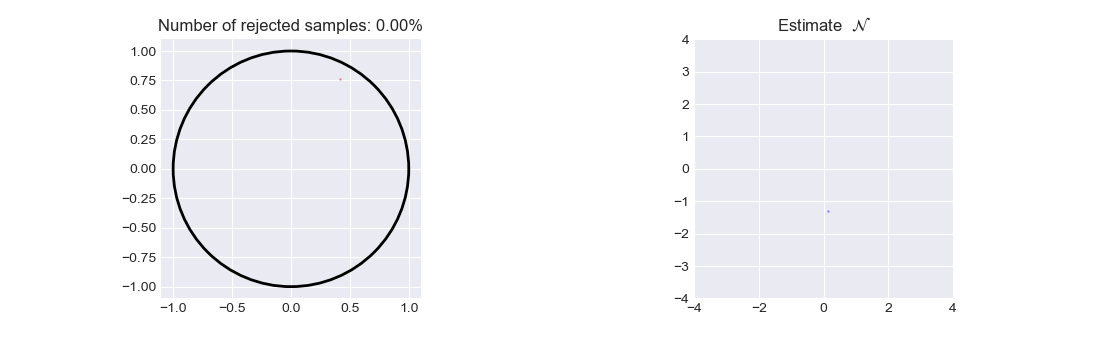

In [ ]:
# Box Muller

def boxmuller():
    def z0(u1, u2):
        return np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
    
    def z1(u1, u2):
        return np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)
    
    num_samples = 10000
    np.random.seed(1)
    x = np.random.uniform(low=0, high=1, size=num_samples)
    y = np.random.uniform(low=0, high=1, size=num_samples)
    c = x**2 + y**2 < 1

    fig, axes = plt.subplots(1, 2, figsize=(11,3.5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax = axes[0]; er = axes[1]; fig.tight_layout(pad=2.5)
    er.set_xlim(0, num_samples)

    circle = plt.Circle((0, 0), 1, fill=False, linewidth=2)
    z0 = z0(x, y)
    z1 = z1(x, y)
    @widgets.interact(n=(1, num_samples, 1))
    def update(n = 1):
        ax.clear(); ax.set_aspect('equal');
        er.clear(); er.set_aspect('equal');
        er.set_ylim(-4, 4);er.set_xlim(-4, 4)
        ax.scatter(x[:n], y[:n], c=c[:n], alpha=0.25, s=1, cmap='coolwarm_r')
        ax.add_patch(circle)


        er.scatter(z0[:n], z1[:n], c='blue', s=1, alpha=0.25)
        # sns.kdeplot(x=z0[:n], y=z1[:n], kind="kde", ax=er, alpha=0.7, color='black')

        ax.set_title(f"Number of rejected samples: {100*(n-sum(c[:n]))/n:.2f}%")
        er.set_title(r"Estimate  $\mathcal{N}$")
        # plt.show()
boxmuller()


### Why it works (in a nutshell):

$r = \sqrt{x^2 + y^2}$ same distribution as 
$r^2 = x^2 + y^2$.

This follows a $\chi_2^2$ (2 degrees of freedom) $\sim \Gamma (1,\frac{1}{2}) \sim Exp(\frac{1}{2})$ $\sim -2 log U_1$

Details:
* https://web.archive.org/web/20180317214751/https://keyonvafa.com/box-muller-transform/
* https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf
* https://probml.github.io/pml-book/book2.html#toc

